# lab 6: translation simple ecoder-decocer over the b3 dataset

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data
import pandas as pd
import unicodedata
import string
import re
import random
from contra_qa.plots.functions  import simple_step_plot
import  matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from nltk.translate.bleu_score import sentence_bleu


% matplotlib inline

### Preparing data

In [2]:
df2 = pd.read_csv("data/boolean3_train.csv")

df2train = df2.iloc[:8500]
df2valid = df2.iloc[8500:]

In [3]:
df2train.tail()

,sentence1,sentence2,and_A,and_B,label
8495,Milton went to Timisoara and Tulcea,Shawn didn't go to Tulcea,Milton went to Timisoara,Milton went to Tulcea,0
8496,Alice has traveled to Giurgiu and Craiova,Alice didn't travel to Craiova,Alice has traveled to Giurgiu,Alice has traveled to Craiova,1
8497,Blanche went to Slatina and Cluj-Napoca,Blanche didn't go to Bucharest,Blanche went to Slatina,Blanche went to Cluj-Napoca,0
8498,Nicole went to Reghin and Blaj,Nicole didn't go to Reghin,Nicole went to Reghin,Nicole went to Blaj,1
8499,Sheryl went to Cluj-Napoca and Hunedoara,Sheryl didn't go to Hunedoara,Sheryl went to Cluj-Napoca,Sheryl went to Hunedoara,1


In [4]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


example = "ddddda'''~~çãpoeéééééÈ'''#$$##@!@!@AAS@#12323fdf"
print("Before:", example)
print()
print("After:", normalizeString(example))

Before: ddddda'''~~çãpoeéééééÈ'''#$$##@!@!@AAS@#12323fdf

After: ddddda capoeeeeeee ! ! aas fdf


In [6]:
pairs_A = list(zip(list(df2train.sentence1.values), list(df2train.and_A.values)))
pairs_B = list(zip(list(df2train.sentence1.values), list(df2train.and_B.values)))
pairs_A = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_A]
pairs_B = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_B]
pairs_A_val = list(zip(list(df2valid.sentence1.values), list(df2valid.and_A.values)))
pairs_B_val = list(zip(list(df2valid.sentence1.values), list(df2valid.and_B.values)))
pairs_A_val = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_A_val]
pairs_B_val = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_B_val]


In [7]:
def readLangs(lang1, lang2, pairs, reverse=False):
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [tuple(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [8]:
eng_enc, eng_dec, pairs_A = readLangs("eng_enc",
                                      "eng_dec",
                                      pairs_A,
                                      reverse=False)

In [9]:
MAX_LENGTH = 20


def filterPair(p):
    cond1 = len(p[0].split(' ')) < MAX_LENGTH
    cond2 = len(p[1].split(' ')) < MAX_LENGTH 
    return cond1 and cond2


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


In [10]:
def prepareData(lang1, lang2, pairs, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, pairs, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData("eng_enc",
                                             "eng_dec",
                                             pairs_A)

Read 8500 sentence pairs
Trimmed to 8500 sentence pairs
Counting words...
Counted words:
eng_enc 685
eng_dec 683


### sentences 2 tensors

In [11]:
example = random.choice(pairs)
print(example)

('marjorie and dan went to reghin', 'marjorie went to reghin')


In [12]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

In [13]:
indexesFromSentence(input_lang,example[0])

[450, 3, 579, 27, 7, 47]

In [14]:
indexesFromSentence(output_lang, example[1])

[618, 20, 5, 51]

In [15]:
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [16]:
input_sen = tensorFromSentence(input_lang,example[0])
output_sen = tensorFromSentence(output_lang, example[1])

print(input_sen)
print()
print(input_sen.shape)
print(input_sen.dtype)
print(output_sen)
print()
print(output_sen.shape)
print(output_sen.dtype)

tensor([[450],
        [  3],
        [579],
        [ 27],
        [  7],
        [ 47],
        [  1]])

torch.Size([7, 1])
torch.int64
tensor([[618],
        [ 20],
        [  5],
        [ 51],
        [  1]])

torch.Size([5, 1])
torch.int64


In [17]:
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [18]:
input_sen, output_sen = tensorsFromPair(example)


print("input\n")
print(input_sen)
print()
print(input_sen.shape)
print(input_sen.dtype)

print("\noutput\n")
print(output_sen)
print()
print(output_sen.shape)
print(output_sen.dtype)

input

tensor([[450],
        [  3],
        [579],
        [ 27],
        [  7],
        [ 47],
        [  1]])

torch.Size([7, 1])
torch.int64

output

tensor([[618],
        [ 20],
        [  5],
        [ 51],
        [  1]])

torch.Size([5, 1])
torch.int64


In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [20]:
hidden_size = 10
eng_enc_v_size = input_lang.n_words
eng_dec_v_size = output_lang.n_words

In [21]:
encoder = EncoderRNN(eng_enc_v_size, hidden_size)
h0 = encoder.initHidden()
print("input_sen:", input_sen.shape, input_sen.dtype)
print("h0:", h0.shape, h0.dtype)

input_sen: torch.Size([7, 1]) torch.int64
h0: torch.Size([1, 1, 10]) torch.float32


In [22]:
max_length = MAX_LENGTH
encoder_outputs = torch.zeros(max_length,
                              encoder.hidden_size,
                              device=device)

input_length = input_sen.size(0)

for ei in range(input_length):
    output, hidden_enc = encoder(input_sen[ei], h0)
    h0 = hidden_enc
    encoder_outputs[ei] = output[0, 0]

print("output:", output.shape, output.dtype)
print("hidden_enc:", hidden_enc.shape, hidden_enc.dtype)

output: torch.Size([1, 1, 10]) torch.float32
hidden_enc: torch.Size([1, 1, 10]) torch.float32


In [23]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [24]:
decoder = DecoderRNN(hidden_size, eng_dec_v_size)

decoder_input = torch.tensor([[SOS_token]], device=device)

decoder_hidden = hidden_enc

target_length = output_sen.size(0)

for di in range(target_length):
    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
    decoder_input = output_sen[di]  # Teacher forcing
    print("decoder_output:", decoder_output.shape, decoder_output.dtype)
    print()
    print("decoder_hidden:", decoder_hidden.shape, decoder_hidden.dtype)    


decoder_output: torch.Size([1, 704]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 704]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 704]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 704]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 704]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32


## Calculate loss over each token of the target language

In [25]:
learning_rate = 0.2
encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [26]:
def train(input_tensor,
          target_tensor,
          encoder,
          decoder,
          encoder_optimizer,
          decoder_optimizer,
          criterion,
          max_length,
          teacher_forcing_ratio=0.5):

    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length,
                                  encoder.hidden_size,
                                  device=device)
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    use_teacher_forcing = True

    if not random.random() < teacher_forcing_ratio:
        use_teacher_forcing = False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            _, topone = decoder_output.topk(1)
            decoder_input = topone.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

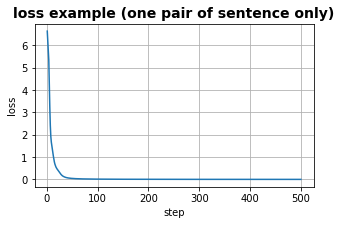

In [27]:
losses = []
for i in range(500):
    loss = train(input_sen,
          output_sen,
          encoder,
          decoder,
          encoder_optimizer,
          decoder_optimizer,
          criterion,
          max_length=MAX_LENGTH)
    losses.append(loss)

simple_step_plot([losses],
                 "loss",
                 "loss example (one pair of sentence only)",
                 "loss_example.png",
                  figsize=(5,3))

In [28]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since):
    now = time.time()
    s = now - since
    return '%s' % asMinutes(s)

0m 7s


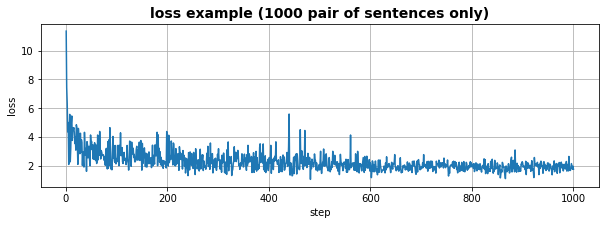

In [29]:
n_iters = 1000
training_pairs_little = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]

losses = []
start = time.time()

for t in training_pairs_little:
    input_sen, output_sen = t    
    loss = train(input_sen,
                 output_sen,
                 encoder,
                 decoder,
                 encoder_optimizer,
                 decoder_optimizer,
                 criterion,
                 max_length=MAX_LENGTH)
    losses.append(loss)

print(timeSince(start))

simple_step_plot([losses],
                 "loss",
                 "loss example ({} pair of sentences only)".format(n_iters),
                 "loss_example.png",
                  figsize=(10,3))

In [30]:
def trainIters(encoder,
               decoder,
               n_iters,
               pairs,
               status_every=100,
               learning_rate=0.01,
               teacher_forcing_ratio=0.5):

    plot_losses = []
    old = 0
    start = time.time()
    all_loss = []

    encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]

    for i, t in enumerate(training_pairs):
        input_sen, output_sen = t
        loss = train(input_sen,
                     output_sen,
                     encoder,
                     decoder,
                     encoder_optimizer,
                     decoder_optimizer,
                     criterion,
                     max_length=MAX_LENGTH,
                     teacher_forcing_ratio=teacher_forcing_ratio)
        plot_losses.append(loss)

        if i % status_every == 0 and i != 0:
            print("mean loss = {:.2f}\n".format(np.mean(plot_losses)))
            print("time in {} steps:".format(status_every), timeSince(start))
            simple_step_plot([plot_losses],
                             "loss",
                             "loss plot (from {} to {})".format(old, i),
                             "loss_example.png",
                             figsize=(10, 3))
            all_loss += plot_losses
            plot_losses = []
            old = i
            start = time.time()
    
    simple_step_plot([all_loss],
                     "loss",
                     "loss over training" ,
                     "loss_example.png",
                     figsize=(15, 3))


mean loss = 1.87

time in 100 steps: 0m 0s
mean loss = 1.91

time in 100 steps: 0m 0s
mean loss = 1.85

time in 100 steps: 0m 0s
mean loss = 1.88

time in 100 steps: 0m 0s
mean loss = 1.84

time in 100 steps: 0m 0s
mean loss = 1.83

time in 100 steps: 0m 0s
mean loss = 1.88

time in 100 steps: 0m 0s
mean loss = 1.86

time in 100 steps: 0m 0s
mean loss = 1.84

time in 100 steps: 0m 0s


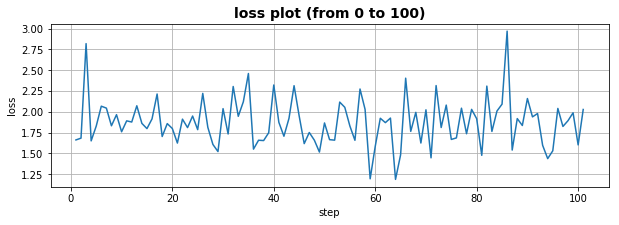

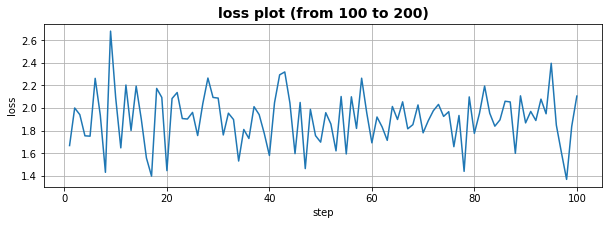

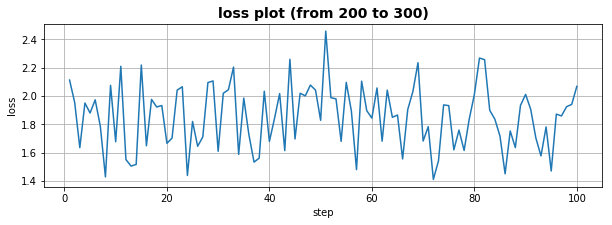

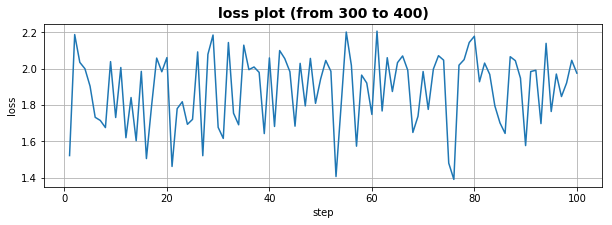

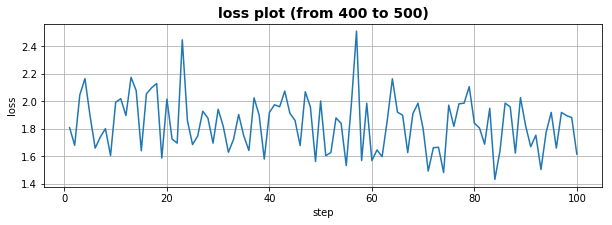

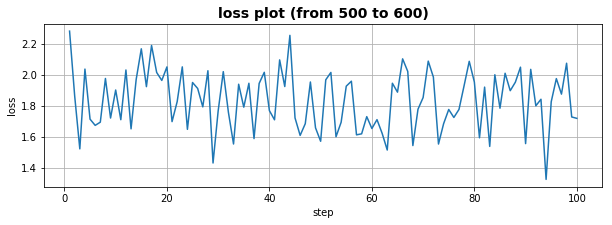

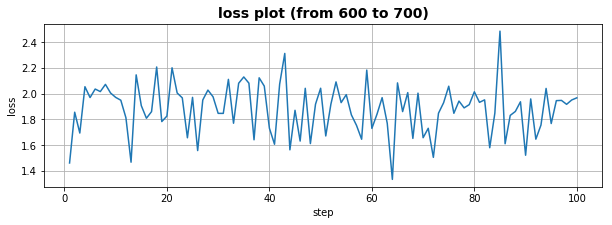

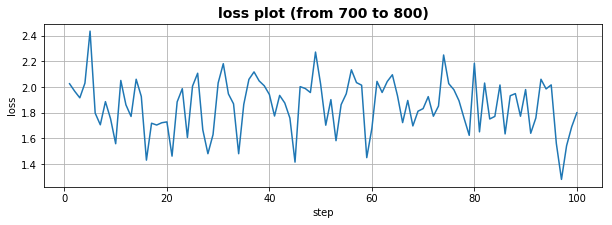

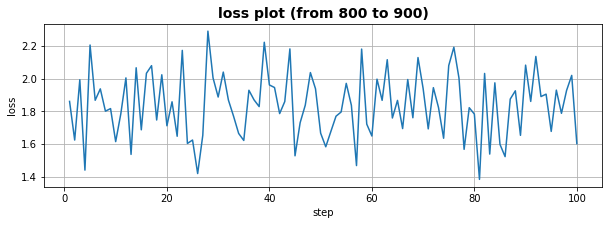

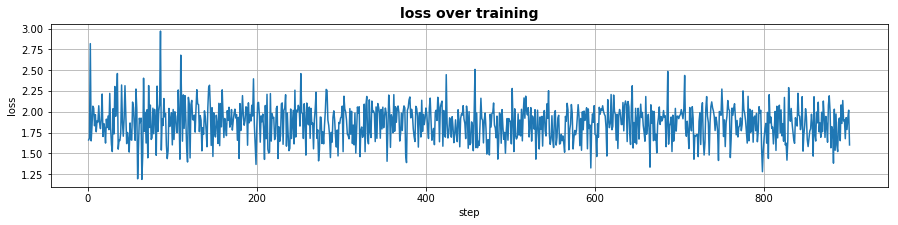

In [31]:
trainIters(encoder=encoder,
           decoder=decoder,
           n_iters=1000,
           pairs=pairs,
           status_every=100,
           learning_rate=0.01,
           teacher_forcing_ratio=0.5)

## translating

In [32]:
def translate(encoder,
              decoder,
              sentence,
              max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(
            max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()

        return " ".join(decoded_words)

## translation of a non trained model

In [33]:
encoder = EncoderRNN(eng_enc_v_size, hidden_size)
decoder = DecoderRNN(hidden_size, eng_dec_v_size)

np.random.shuffle(pairs)

In [34]:
for t in pairs[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoder,
                                   decoder,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1] + ' <EOS>'
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    print("blue score = {:.2f}".format(score))
    print()


input_sentence : melinda went to oradea and turda
neural translation : sherry edgar jaime norma sherry amber pauline cathy norma salvador alberto cathy cathy cathy norma salvador cathy cathy cathy norma
reference translation : melinda went to oradea <EOS>
blue score = 0.00

input_sentence : marie and claudia have visited bucharest
neural translation : sherry edgar ken lorraine mangalia norma salvador alberto cathy cathy norma salvador cathy cathy cathy norma salvador cathy cathy cathy
reference translation : marie has visited bucharest <EOS>
blue score = 0.00

input_sentence : barbara and sam went to giurgiu
neural translation : sherry edgar ken lorraine mangalia norma salvador alberto cathy cathy norma salvador cathy cathy cathy norma salvador cathy cathy cathy
reference translation : barbara went to giurgiu <EOS>
blue score = 0.00



## Training some models and observing its translation

mean loss = 3.75

time in 1000 steps: 0m 7s
mean loss = 2.34

time in 1000 steps: 0m 8s
mean loss = 2.10

time in 1000 steps: 0m 7s
mean loss = 1.98

time in 1000 steps: 0m 7s
input_sentence : melinda went to oradea and turda
neural translation : went to bucharest <EOS>
reference translation : melinda went to oradea <EOS>
blue score = 0.55

input_sentence : marie and claudia have visited bucharest
neural translation : has traveled to bucharest <EOS>
reference translation : marie has visited bucharest <EOS>
blue score = 0.62

input_sentence : barbara and sam went to giurgiu
neural translation : went to bucharest <EOS>
reference translation : barbara went to giurgiu <EOS>
blue score = 0.55



/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


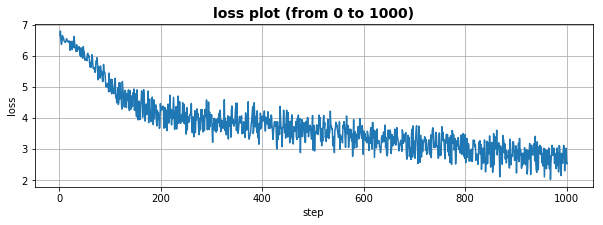

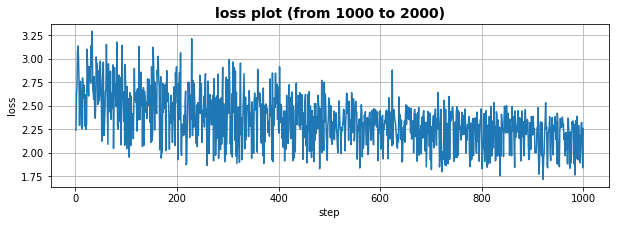

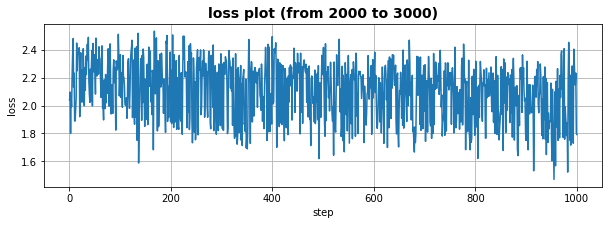

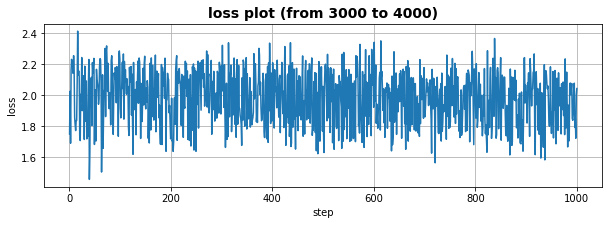

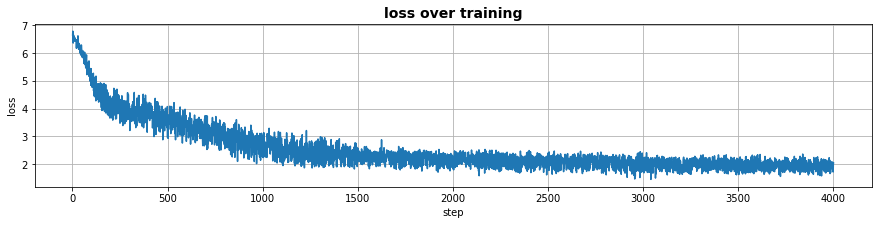

In [35]:
encoder = EncoderRNN(eng_enc_v_size, hidden_size)
decoder = DecoderRNN(hidden_size, eng_dec_v_size)

trainIters(encoder=encoder,
           decoder=decoder,
           n_iters=5000,
           pairs=pairs,
           status_every=1000,
           learning_rate=0.01,
           teacher_forcing_ratio=1)


for t in pairs[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoder,
                                   decoder,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1] + ' <EOS>'
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    print("blue score = {:.2f}".format(score))
    print()

mean loss = 2.50

time in 1000 steps: 0m 5s
mean loss = 3.03

time in 1000 steps: 0m 7s
mean loss = 2.52

time in 1000 steps: 0m 6s
mean loss = 2.47

time in 1000 steps: 0m 6s
input_sentence : melinda went to oradea and turda
neural translation : went has traveled to <EOS>
reference translation : melinda went to oradea <EOS>
blue score = 0.88

input_sentence : marie and claudia have visited bucharest
neural translation : has has traveled to <EOS>
reference translation : marie has visited bucharest <EOS>
blue score = 0.80

input_sentence : barbara and sam went to giurgiu
neural translation : went has traveled to <EOS>
reference translation : barbara went to giurgiu <EOS>
blue score = 0.88



/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


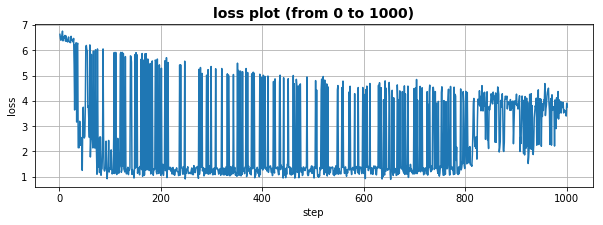

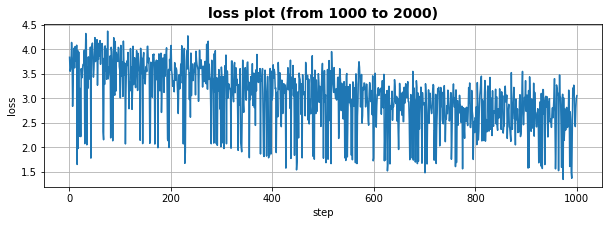

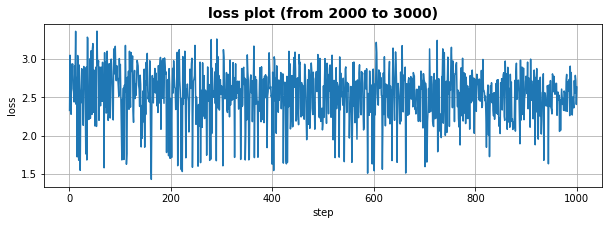

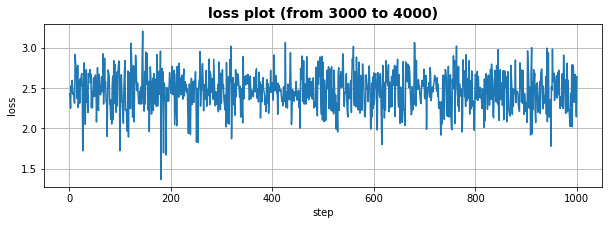

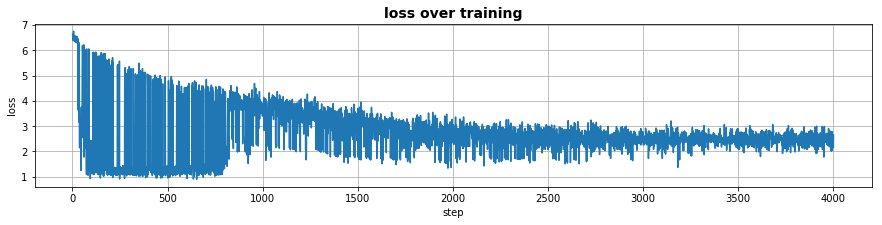

In [36]:
encoder = EncoderRNN(eng_enc_v_size, hidden_size)
decoder = DecoderRNN(hidden_size, eng_dec_v_size)

trainIters(encoder=encoder,
           decoder=decoder,
           n_iters=5000,
           pairs=pairs,
           status_every=1000,
           learning_rate=0.01,
           teacher_forcing_ratio=0.2)


for t in pairs[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoder,
                                   decoder,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1] + ' <EOS>'
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    print("blue score = {:.2f}".format(score))
    print()

mean loss = 2.47

time in 1000 steps: 0m 7s
mean loss = 1.90

time in 1000 steps: 0m 7s
mean loss = 2.33

time in 1000 steps: 0m 8s
mean loss = 2.36

time in 1000 steps: 0m 6s
input_sentence : melinda went to oradea and turda
neural translation : bill has traveled <EOS>
reference translation : melinda went to oradea <EOS>
blue score = 0.55

input_sentence : marie and claudia have visited bucharest
neural translation : flora has traveled <EOS>
reference translation : marie has visited bucharest <EOS>
blue score = 0.65

input_sentence : barbara and sam went to giurgiu
neural translation : courtney has traveled <EOS>
reference translation : barbara went to giurgiu <EOS>
blue score = 0.55



/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


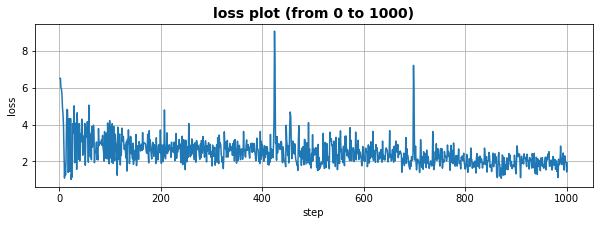

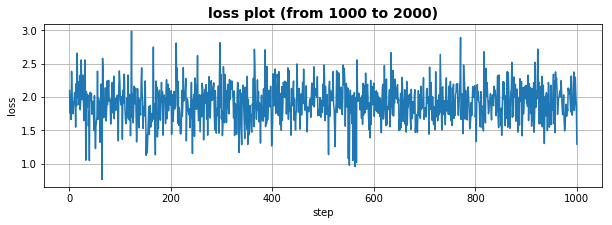

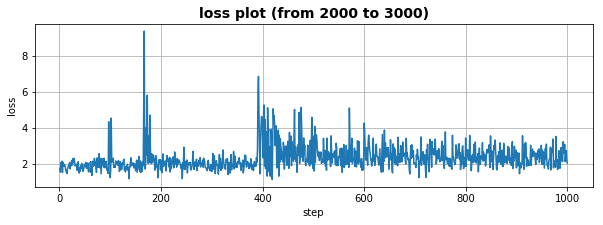

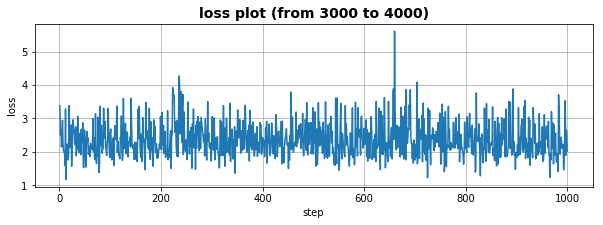

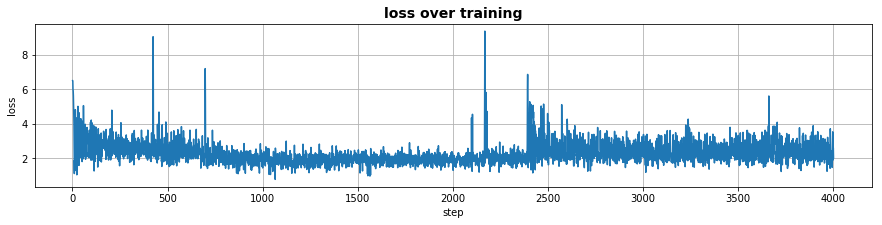

In [37]:
encoder = EncoderRNN(eng_enc_v_size, hidden_size)
decoder = DecoderRNN(hidden_size, eng_dec_v_size)

trainIters(encoder=encoder,
           decoder=decoder,
           n_iters=5000,
           pairs=pairs,
           status_every=1000,
           learning_rate=0.2,
           teacher_forcing_ratio=0.2)


for t in pairs[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoder,
                                   decoder,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1] + ' <EOS>'
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    print("blue score = {:.2f}".format(score))
    print()

mean loss = 6.76

time in 1000 steps: 0m 10s
mean loss = 8.41

time in 1000 steps: 0m 9s
mean loss = 9.14

time in 1000 steps: 0m 10s
mean loss = 10.40

time in 1000 steps: 0m 11s
input_sentence : melinda went to oradea and turda
neural translation : diane has traveled to baia mare <EOS>
reference translation : melinda went to oradea <EOS>
blue score = 0.73

input_sentence : marie and claudia have visited bucharest
neural translation : diane has visited slobozia <EOS>
reference translation : marie has visited bucharest <EOS>
blue score = 0.62

input_sentence : barbara and sam went to giurgiu
neural translation : erica went traveled <EOS>
reference translation : barbara went to giurgiu <EOS>
blue score = 0.65



/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


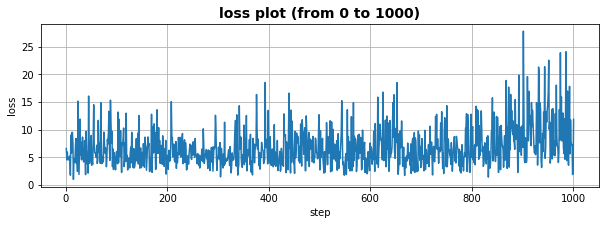

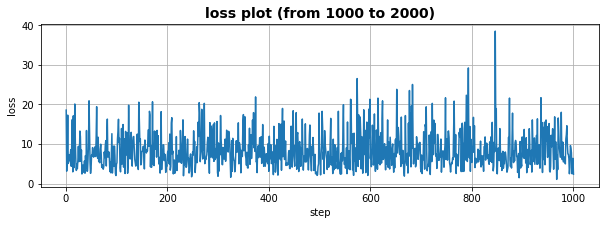

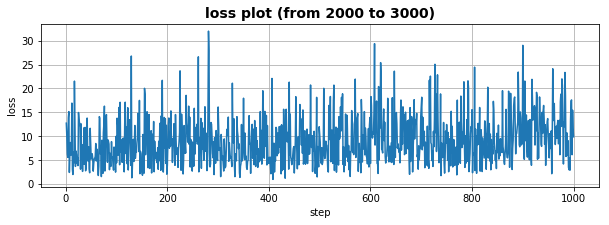

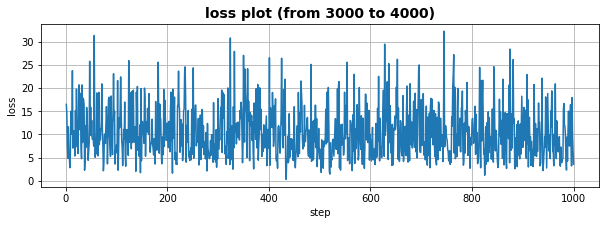

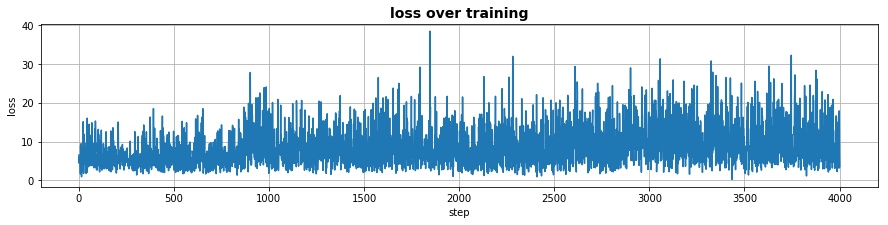

In [38]:
hidden_size = 100

encoder = EncoderRNN(eng_enc_v_size, hidden_size)
decoder = DecoderRNN(hidden_size, eng_dec_v_size)

trainIters(encoder=encoder,
           decoder=decoder,
           n_iters=5000,
           pairs=pairs,
           status_every=1000,
           learning_rate=0.2,
           teacher_forcing_ratio=0.2)


for t in pairs[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoder,
                                   decoder,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1] + ' <EOS>'
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    print("blue score = {:.2f}".format(score))
    print()

In [39]:
np.random.shuffle(pairs)
all_blue = []
for t in pairs:
    neural_translation = translate(encoder,
                                   decoder,
                                   t[0],
                                   max_length=MAX_LENGTH)
    reference = t[1] + ' <EOS>'
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    all_blue.append(score)
    
print("mean blue score over training data = {:.3f}".format(np.mean(all_blue)))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


mean blue score over training data = 0.592


In [40]:
_, _, pairs_val = prepareData("eng_enc",
                              "eng_dec",
                              pairs_A_val)

Read 1500 sentence pairs
Trimmed to 1500 sentence pairs
Counting words...
Counted words:
eng_enc 652
eng_dec 612


In [41]:
for t in pairs_val[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoder,
                                   decoder,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1] + ' <EOS>'
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    print("blue score = {:.2f}".format(score))
    print()

input_sentence : ruben has visited arad and baia mare
neural translation : diane has traveled baia mare mare mare mare mare mare mare mare mare mare mare mare mare mare mare mare
reference translation : ruben has visited arad <EOS>
blue score = 0.47

input_sentence : elmer and ken have visited tulcea
neural translation : diane has visited blaj <EOS>
reference translation : elmer has visited tulcea <EOS>
blue score = 0.62

input_sentence : willard has visited hunedoara and oradea
neural translation : nancy went traveled mare <EOS>
reference translation : willard has visited hunedoara <EOS>
blue score = 0.67



/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [42]:
all_blue = []
for t in pairs_val:
    neural_translation = translate(encoder,
                                   decoder,
                                   t[0],
                                   max_length=MAX_LENGTH)
    reference = t[1] + ' <EOS>'
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    all_blue.append(score)
    
print("mean blue score over valid data = {:.3f}".format(np.mean(all_blue)))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


mean blue score over valid data = 0.594


In [43]:
_, _, pairs_val = prepareData("eng_enc",
                              "eng_dec",
                              pairs_B_val)

Read 1500 sentence pairs
Trimmed to 1500 sentence pairs
Counting words...
Counted words:
eng_enc 652
eng_dec 608


In [44]:
all_blue = []
for t in pairs_val:
    neural_translation = translate(encoder,
                                   decoder,
                                   t[0],
                                   max_length=MAX_LENGTH)
    reference = t[1] + ' <EOS>'
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    all_blue.append(score)
    
print("mean blue score over valid data = {:.3f}".format(np.mean(all_blue)))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


mean blue score over valid data = 0.598


In [45]:
for t in pairs_val[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoder,
                                   decoder,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1] + ' <EOS>'
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    print("blue score = {:.2f}".format(score))
    print()

input_sentence : ruben has visited arad and baia mare
neural translation : diane has traveled baia mare mare mare mare mare mare mare mare mare mare mare mare mare mare mare mare
reference translation : ruben has visited baia mare <EOS>
blue score = 0.30

input_sentence : elmer and ken have visited tulcea
neural translation : diane has visited blaj <EOS>
reference translation : ken has visited tulcea <EOS>
blue score = 0.62

input_sentence : willard has visited hunedoara and oradea
neural translation : nancy went traveled mare <EOS>
reference translation : willard has visited oradea <EOS>
blue score = 0.67



/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
